In [32]:
import pandas as pd
import matplotlib.pyplot as plt

In [228]:
df = pd.read_json('datascience_assignment_data.json')

In [229]:
df.head()

,distance,preorder,timestamp,tz,venue_tags,weather
0,3.123568,False,2018-04-10 09:36:53.754,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny
1,2.489746,False,2018-04-10 10:27:39.279,{'zone': 'Europe/Helsinki'},"[sushi, fish]",sunny
2,1.378161,False,2018-04-10 10:35:22.101,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny
3,2.390313,False,2018-04-10 12:32:17.173,{'zone': 'Europe/Helsinki'},"[sushi, fish]",sunny
4,2.493781,False,2018-04-10 13:13:56.298,{'zone': 'Europe/Helsinki'},"[sushi, japanese, gourmet]",sunny


In [230]:
#preorder is always false so we can drop it from consideration
df['preorder'].unique()

array([False])

In [231]:
df = df.drop(['preorder'], axis=1)

In [232]:
#timezone is always constant Europe/Helsinki so we can drop it from consideration
s = set( val for dic in df['tz'].values for val in dic.values())
s

{'Europe/Helsinki'}

In [233]:
df = df.drop(['tz'], axis=1)

In [234]:
#Class distribution of venue tags is highly imbalanced to a few classes
df['venue_tags'].apply(pd.Series).stack().value_counts()

sushi          2590
japanese       2359
gourmet        2359
fresh          1130
fish            233
pita              6
lunch             5
lebanese          5
meze              5
fast              5
salad             5
sandwich          4
vegetarian        4
wrap              3
asian             3
hangover          3
spicy             3
cheap             3
smoothie          3
noodles           3
pizza             3
meatballs         2
meat              2
american          2
italian           2
soup              2
vietnamese        2
fafas             1
hamburger         1
artisan           1
napolese          1
café              1
street food       1
falafel           1
fries             1
thai              1
dessert           1
rice              1
vegan             1
chicken           1
family            1
coffee            1
healthy           1
dtype: int64

In [235]:
#With weather the class distirubtion is much more even
#There seems to be a possible preposition to use the app more when it is raining
df['weather'].value_counts()

rain            955
sunny           740
mostly_sunny    580
overcast        332
Name: weather, dtype: int64

In [225]:
df.set_index('timestamp', inplace=True)

## Relationship between weather and order amount

In [239]:
#Approximation on how many hours are of each weather type
hourly_sum = df.groupby([pd.Grouper(key='timestamp',freq='H'),df.weather]).size().reset_index(name='count')
hourly_sum[:10]

,timestamp,weather,count
0,2018-04-10 09:00:00,sunny,1
1,2018-04-10 10:00:00,sunny,2
2,2018-04-10 12:00:00,sunny,1
3,2018-04-10 13:00:00,sunny,2
4,2018-04-10 14:00:00,sunny,2
5,2018-04-10 17:00:00,sunny,2
6,2018-04-11 09:00:00,rain,1
7,2018-04-11 10:00:00,rain,3
8,2018-04-11 13:00:00,rain,1
9,2018-04-11 14:00:00,rain,3


In [240]:
hourly_sum_rain = hourly_sum[hourly_sum['weather'] == 'rain'].shape[0]
hourly_sum_sunny = hourly_sum[hourly_sum['weather'] == 'sunny'].shape[0]
hourly_sum_mostly_sunny = hourly_sum[hourly_sum['weather'] == 'mostly_sunny'].shape[0]
hourly_sum_overcast = hourly_sum[hourly_sum['weather'] == 'overcast'].shape[0]

In [224]:
print("orders in rain: " + str(955 / hourly_sum_rain) + " per hour")

orders in rain: 2.8851963746223563 per hour


In [241]:
print("orders in sunny: " + str(740 / hourly_sum_sunny) + " per hour")

orders in sunny: 2.364217252396166 per hour


In [222]:
print("orders in mostly sunny : " + str(580 / hourly_sum_mostly_sunny) + " per hour")

orders in mostly sunny : 2.600896860986547 per hour


In [221]:
print("orders in mostly overcast : " + str(332 / hourly_sum_overcast) + " per hour")

orders in mostly overcast : 2.8620689655172415 per hour


__Conclusion: Worse weather attracts more customers to the application__

## Relationship between time and order amount

In [338]:
#Adjust freq to W for weekly orders and M to monthly orders
daily_sum = df.groupby(pd.Grouper(key='timestamp',freq='D')).count()
daily_sum.rename(columns={'distance':'amount'}, inplace=True)

In [339]:
daily_sum.head()

,amount,venue_tags,weather
timestamp,,,
2018-04-10,10,10,10
2018-04-11,12,12,12
2018-04-12,14,14,14
2018-04-13,20,20,20
2018-04-14,27,27,27


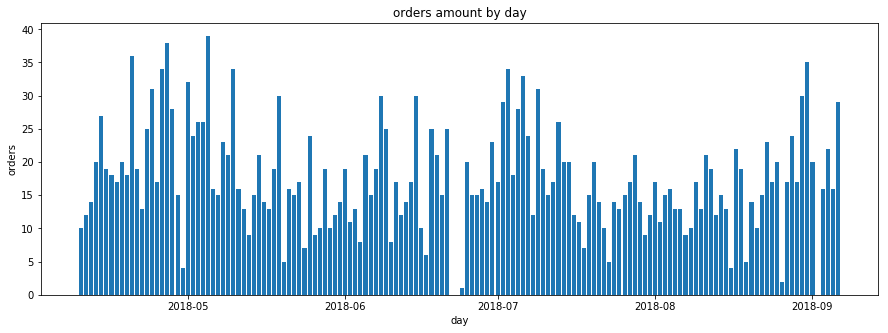

In [340]:
plt.figure(figsize=(15,5))
plt.bar(daily_sum.index, daily_sum.amount)
plt.xlabel('day')
plt.ylabel('orders')
plt.title('orders amount by day')
plt.show()

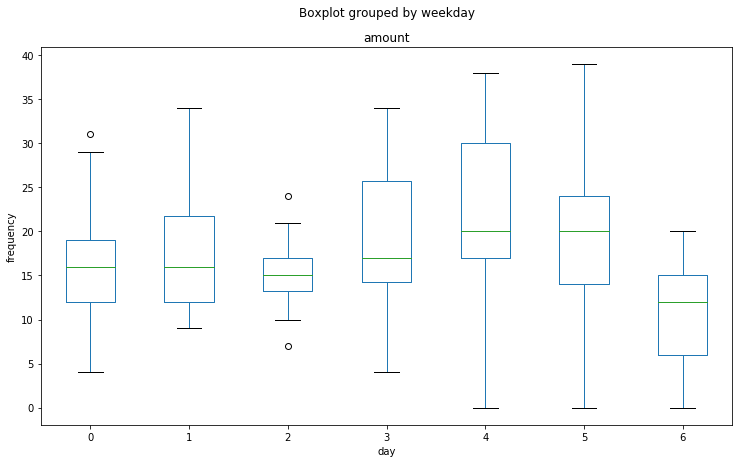

In [341]:
#add day column to group_by
daily_sum['weekday'] = daily_sum.index.weekday

#application use increases till friday after which it decreases
daily_sum.groupby(['weekday']).amount.sum()


daily_sum.boxplot(column='amount', by='weekday', figsize=(12,7), grid=False)
plt.xlabel('day')
plt.ylabel('frequency')
plt.show()

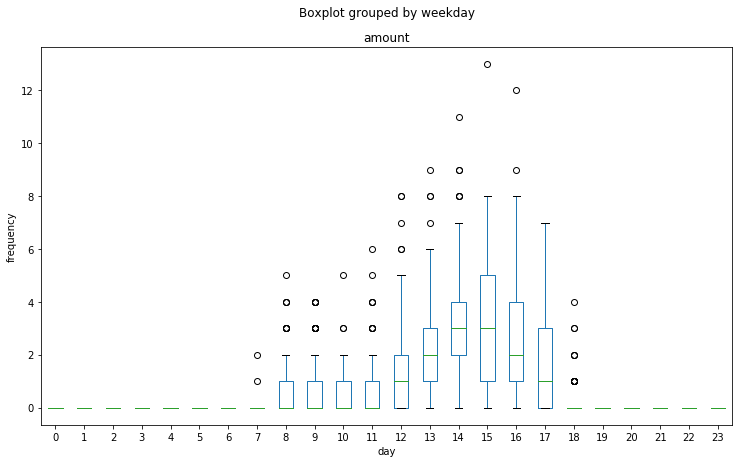

In [330]:
hourly_sum = df.groupby(pd.Grouper(key='timestamp',freq='H')).count()
daily_sum.rename(columns={'distance':'amount'}, inplace=True)



daily_sum.boxplot(column='amount', by='weekday', figsize=(12,7), grid=False)
plt.xlabel('day')
plt.ylabel('frequency')
plt.show()

## Relationship between distance and weather

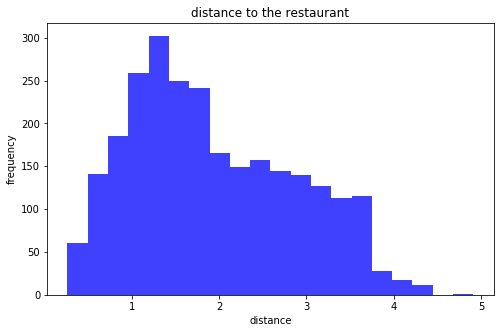

In [305]:
plt.figure(figsize=(8,5))
plt.hist(df.distance,20, facecolor='blue', alpha=0.75)
plt.xlabel('distance')
plt.ylabel('frequency')
plt.title('distance to the restaurant')
plt.show()

In [121]:
distance_weather_rain = df.loc[df['weather'] == 'rain']
distance_weather_sunny = df.loc[df['weather'] == 'sunny']
distance_weather_mostly_sunny = df.loc[df['weather'] == 'mostly_sunny']
distance_weather_overcast = df.loc[df['weather'] == 'overcast']

In [122]:
#weather does not seem to have a large effect on user distance to the restaurant 
for weather in [distance_weather_rain, distance_weather_sunny,distance_weather_mostly_sunny,distance_weather_overcast]:
    print(str(weather['weather'].iloc[0]) + " median: " + str(weather.median().distance))

rain median: 1.7960506616
sunny median: 1.76208313405
mostly_sunny median: 1.6918655821000002
overcast median: 1.80655828565


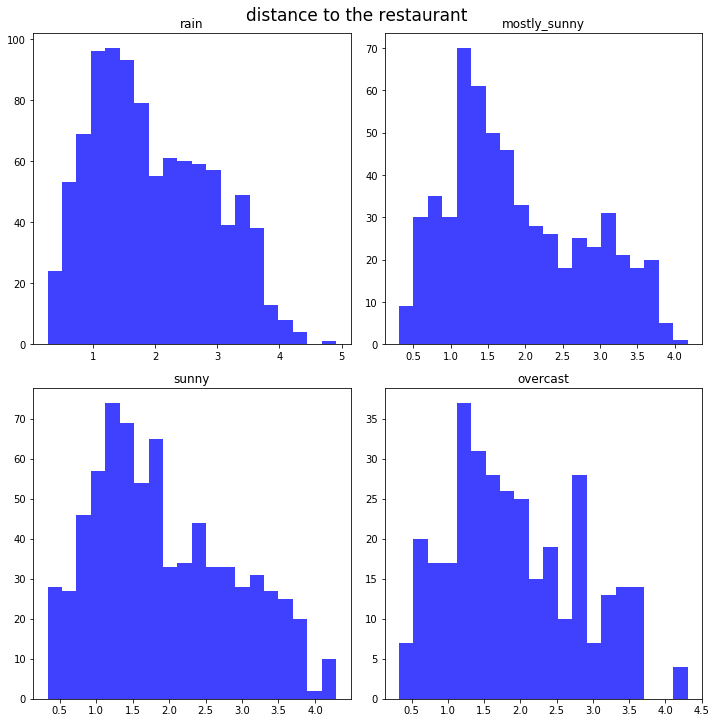

In [123]:
#This can be also seen in the histograms
fig, axs = plt.subplots(nrows=2, ncols=2, tight_layout=True,figsize=(10, 10))

# We can set the number of bins with the `bins` kwarg
axs[0,0].hist(distance_weather_rain.distance, bins=20, facecolor='blue', alpha=0.75)
axs[1,0].hist(distance_weather_sunny.distance, bins=20, facecolor='blue', alpha=0.75)
axs[0,1].hist(distance_weather_mostly_sunny.distance, bins=20, facecolor='blue', alpha=0.75)
axs[1,1].hist(distance_weather_overcast.distance, bins=20, facecolor='blue', alpha=0.75)

axs[0,0].set_title('rain')
axs[1,0].set_title('sunny')
axs[0,1].set_title('mostly_sunny')
axs[1,1].set_title('overcast')

fig.suptitle('distance to the restaurant', y=1.00, fontsize=17)

plt.show()

## 